In [3]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://gitlab.com/secml/secml

Training of classifier complete!
Initial poisoning sample features: CArray([0.03304  0.014706 0.113725 ... 0.003476 0.011514 0.100253])
Initial poisoning sample label: 1
Attack started...
2021-11-26 15:34:23,390 - COptimizerPGDLS.0x7fd8830c3048 - WARNING - Maximum iterations reached. Exiting.
2021-11-26 15:36:52,036 - COptimizerPGDLS.0x7fd8830c3320 - WARNING - Maximum iterations reached. Exiting.
2021-11-26 15:40:04,244 - COptimizerPGDLS.0x7fd8830f4128 - WARNING - Maximum iterations reached. Exiting.
2021-11-26 15:41:14,839 - COptimizerPGDLS.0x7fd8830f1780 - WARNING - Maximum iterations reached. Exiting.
2021-11-26 15:41:30,865 - COptimizerPGDLS.0x7fd8830e7f98 - WARNING - Maximum iterations reached. Exiting.
2021-11-26 15:42:33,100 - COptimizerPGDLS.0x7fd8830f1d30 - WARNING - Maximum iterations reached. Exiting.
2021-11-26 15:45:28,387 - COptimizerPGDLS.0x7fd89a000a58 - WARNING - Maximum iterations reached. Exiting.
2021-11-26 15:47:44,250 - COptimizerPGDLS.0x7fd89a013e10 - WARNING - M

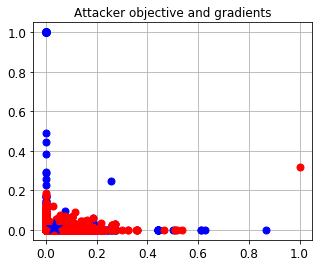

In [5]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 3000  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_ridge_adv = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



In [7]:
import pickle
with open('pois_ds_ridge_adv','wb') as file:
    pickle.dump(pois_ds_ridge_adv,file)

In [13]:
pois_ds_ridge_adv_X_array = pois_ds_ridge_adv.X.tondarray()
pois_ds_ridge_adv_y_array = pois_ds_ridge_adv.Y.tondarray()
with open('pois_ds_ridge_adv_X_array','wb') as file:
    pickle.dump(pois_ds_ridge_adv_X_array,file)
with open('pois_ds_ridge_adv_y_array','wb') as file:
    pickle.dump(pois_ds_ridge_adv_y_array,file)


3000


In [ ]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 450  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_ridge_15 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.       ... 0.00098  0.000601 0.000694])
Initial poisoning sample label: 0
Attack started...
2021-11-22 20:24:09,061 - COptimizerPGDLS.0x7fd88a1862e8 - WARNING - Maximum iterations reached. Exiting.


In [ ]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 600  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_ridge_20 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



In [ ]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 750  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_ridge_25 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



In [ ]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 900  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_ridge_30 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



In [ ]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 1050  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_ridge_35 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



In [ ]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 1200  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_ridge_40 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



In [ ]:
import numpy as np

pois_ds_ridge_10_array = pois_ds_ridge_10.X.tondarray()
pois_ds_ridge_15_array = pois_ds_ridge_15.X.tondarray()
pois_ds_ridge_20_array = pois_ds_ridge_20.X.tondarray()
pois_ds_ridge_25_array = pois_ds_ridge_25.X.tondarray()
pois_ds_ridge_30_array = pois_ds_ridge_30.X.tondarray()
pois_ds_ridge_35_array = pois_ds_ridge_35.X.tondarray()
pois_ds_ridge_40_array = pois_ds_ridge_40.X.tondarray()
# np.savetxt('logistic_pois_ds',(pois_ds_logistic_10_array,pois_ds_logistic_15_array,pois_ds_logistic_20_array,pois_ds_logistic_25_array,pois_ds_logistic_30_array,pois_ds_logistic_35_array,pois_ds_logistic_40_array),fmt='%s')



In [ ]:
import pickle

with open('ridge_pois_ds_10','wb') as file:
    pickle.dump(pois_ds_ridge_10_array,file)
    
with open('ridge_pois_ds_15','wb') as file:
    pickle.dump(pois_ds_ridge_15_array,file)

with open('ridge_pois_ds_20','wb') as file:
    pickle.dump(pois_ds_ridge_20_array,file)

    
with open('ridge_pois_ds_25','wb') as file:
    pickle.dump(pois_ds_ridge_25_array,file)


with open('ridge_pois_ds_30','wb') as file:
    pickle.dump(pois_ds_ridge_30_array,file)

with open('ridge_pois_ds_35','wb') as file:
    pickle.dump(pois_ds_ridge_35_array,file)

with open('ridge_pois_ds_40','wb') as file:
    pickle.dump(pois_ds_ridge_40_array,file)


In [ ]:
import numpy as np

pois_ds_ridge_10_y_array = pois_ds_ridge_10.Y.tondarray()
pois_ds_ridge_15_y_array = pois_ds_ridge_15.Y.tondarray()
pois_ds_ridge_20_y_array = pois_ds_ridge_20.Y.tondarray()
pois_ds_ridge_25_y_array = pois_ds_ridge_25.Y.tondarray()
pois_ds_ridge_30_y_array = pois_ds_ridge_30.Y.tondarray()
pois_ds_ridge_35_y_array = pois_ds_ridge_35.Y.tondarray()
pois_ds_ridge_40_y_array = pois_ds_ridge_40.Y.tondarray()

print(pois_ds_ridge_25_y_array.shape)

import pickle

with open('ridge_pois_ds_y_10','wb') as file:
    pickle.dump(pois_ds_ridge_10_y_array,file)


with open('ridge_pois_ds_y_15','wb') as file:
    pickle.dump(pois_ds_ridge_15_y_array,file)

with open('ridge_pois_ds_y_20','wb') as file:
    pickle.dump(pois_ds_ridge_20_y_array,file)

with open('ridge_pois_ds_y_25','wb') as file:
    pickle.dump(pois_ds_ridge_25_y_array,file)

with open('ridge_pois_ds_y_30','wb') as file:
    pickle.dump(pois_ds_ridge_30_y_array,file)

with open('ridge_pois_ds_y_35','wb') as file:
    pickle.dump(pois_ds_ridge_35_y_array,file)

with open('ridge_pois_ds_y_40','wb') as file:
    pickle.dump(pois_ds_ridge_40_y_array,file)





In [ ]:
with open('ridge_pois_ds_y_30', 'rb') as file_1:
    pois_ds_ridge_y_array = pickle.load(file_1)
print(pois_ds_ridge_y_array.shape)

In [ ]:
valid_x_array = valid_x.tondarray()
valid_y_array = valid_y.tondarray()
test_x_array = test_x.tondarray()
test_y_array = test_y.tondarray()

with open('spambase_valid_x','wb') as file:
    pickle.dump(valid_x_array,file)

with open('spambase_valid_y','wb') as file:
    pickle.dump(valid_y_array,file)
    
with open('spambase_test_x','wb') as file:
    pickle.dump(test_x_array,file)

with open('spambase_test_y','wb') as file:
    pickle.dump(test_y_array,file)


In [ ]:
#特征选择


#干净的样本
tr_X_array = tr_X.tondarray()
tr_y_array = tr.Y.tondarray()

print(tr_X_array.shape)


with open('ridge_tr_X','wb') as file:
    pickle.dump(tr_X_array,file)
    
with open('ridge_tr_y','wb') as file:
    pickle.dump(tr_y_array,file)
    
train_x_array_list = tr_X_array.tolist()
train_y_array_list = tr_y_array.tolist()
feature_names = df.columns.values[:-1]



# print(train_x_array_list)


#对抗样本+干净样本
# pois_ds_ridge_40_list = pois_ds_ridge_40_array.tolist()
# print(len(pois_ds_ridge_40_list))
# print(len(train_x_array_list))

# train_x_array_list = train_x_array_list+pois_ds_ridge_40_list
# train_y_array_list = train_y_array_list+pois_ds_ridge_40_y_array.tolist()


import heapq
from sklearn.linear_model import Ridge
import numpy as np
clf = Ridge(alpha=1.0)
clf.fit(train_x_array_list, train_y_array_list)
coef_ridge = clf.coef_
print(coef_ridge)
coef_ridge_list = coef_ridge.tolist()
max_5_feature_index_list = map(coef_ridge_list.index, heapq.nlargest(5, coef_ridge_list))
max_5_feature_index_list_number = list(max_5_feature_index_list)
selected_features_Ridge = []
for i, enum in enumerate(max_5_feature_index_list_number):
    selected_features_Ridge.append(feature_names[enum])
print(selected_features_Ridge)





# 10%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [53, 48, 9, 20, 56]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [53, 48, 9, 20, 56, 17, 51, 39, 13, 4]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [53, 48, 9, 20, 56, 17, 51, 39, 13, 4, 33, 19, 18, 2, 15]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [53, 48, 9, 20, 56, 17, 51, 39, 13, 4, 33, 19, 18, 2, 15, 31, 14, 10, 3, 36]

# 15%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [56, 20, 18, 51, 22]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [56, 20, 18, 51, 22, 9, 41, 15, 34, 33]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [56, 20, 18, 51, 22, 9, 41, 15, 34, 33, 5, 42, 37, 43, 52]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [56, 20, 18, 51, 22, 9, 41, 15, 34, 33, 5, 42, 37, 43, 52, 6, 35, 36, 3, 19]

# 20%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [37, 56, 20, 49, 51]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [37, 56, 20, 49, 51, 18, 38, 9, 52, 15]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [37, 56, 20, 49, 51, 18, 38, 9, 52, 15, 41, 19, 5, 22, 4]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [37, 56, 20, 49, 51, 18, 38, 9, 52, 15, 41, 19, 5, 22, 4, 34, 6, 3, 33, 39]



# 25%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [37, 56, 52, 38, 20]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [37, 56, 52, 38, 20, 51, 9, 41, 15, 5]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [37, 56, 52, 38, 20, 51, 9, 41, 15, 5, 4, 18, 49, 14, 39]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [37, 56, 52, 38, 20, 51, 9, 41, 15, 5, 4, 18, 49, 14, 39, 19, 33, 7, 28, 6]


# 30%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [37, 56, 52, 15, 20]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [37, 56, 52, 15, 20, 38, 5, 18, 51, 19]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [37, 56, 52, 15, 20, 38, 5, 18, 51, 19, 33, 9, 3, 4, 41]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [37, 56, 52, 15, 20, 38, 5, 18, 51, 19, 33, 9, 3, 4, 41, 7, 6, 14, 28, 48]

# 35%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [37, 56, 49, 38, 9]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [37, 56, 49, 38, 9, 5, 15, 28, 20, 34]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [37, 56, 49, 38, 9, 5, 15, 28, 20, 34, 33, 39, 52, 3, 18]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [37, 56, 49, 38, 9, 5, 15, 28, 20, 34, 33, 39, 52, 3, 18, 14, 19, 4, 0, 48]

# 40%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [56, 49, 38, 9, 37]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [56, 49, 38, 9, 37, 5, 28, 15, 33, 3]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [56, 49, 38, 9, 37, 5, 28, 15, 33, 3, 20, 30, 39, 18, 17]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [56, 49, 38, 9, 37, 5, 28, 15, 33, 3, 20, 30, 39, 18, 17, 48, 22, 4, 51, 34]



In [ ]:
import difflib

# s1 = [1, 2, 3]
# s2 = [1, 2, 4]

# 10%投毒Ridge投毒之前/之后特征选择:
s1 = set([18, 56, 15, 20, 5])  
s2 = set([56, 45, 47, 9, 27])
s3 = set([18, 56, 15, 20, 51, 6, 22, 24, 52, 5]) 
s4 = set([56, 45, 47, 9, 27, 37, 20, 5, 15, 1])
s5 = set([18, 56, 15, 20, 51, 6, 22, 24, 52, 5, 4, 23, 25, 26, 7]) 
s6 = set([56, 45, 47, 9, 27, 37, 20, 5, 15, 1, 25, 18, 29, 52, 36])
s7 = set([18, 56, 15, 20, 51, 6, 22, 24, 52, 5, 4, 23, 25, 26, 7, 21, 2, 16, 36, 17]) 
s8 = set( [56, 45, 47, 9, 27, 37, 20, 5, 15, 1, 25, 18, 29, 52, 36, 4, 14, 35, 51, 16])


# 5 : [18, 56, 15, 20, 51] -> [56, 45, 47, 9, 27]
# 10: [18, 56, 15, 20, 51, 6, 22, 24, 52, 5] -> [56, 45, 47, 9, 27, 37, 20, 5, 15, 1]
# 15: [18, 56, 15, 20, 51, 6, 22, 24, 52, 5, 4, 23, 25, 26, 7] -> [56, 45, 47, 9, 27, 37, 20, 5, 15, 1, 25, 18, 29, 52, 36]
# 20: [18, 56, 15, 20, 51, 6, 22, 24, 52, 5, 4, 23, 25, 26, 7, 21, 2, 16, 36, 17] -> [56, 45, 47, 9, 27, 37, 20, 5, 15, 1, 25, 18, 29, 52, 36, 4, 14, 35, 51, 16]



In [ ]:
import difflib
import pandas as pd
import matplotlib.pyplot as plt

list_onion = [s1, s2, s3, s4, s5, s6, s7, s8]
ratio_10_ = [0.2, 0.2, 0.4, 0.5]
ratio_15_ = [0.4, 0.5, 0.6666666666666666, 0.65]
ratio_20_ = [0.4, 0.6, 0.6, 0.65]
ratio_25_ = [0.4, 0.5, 0.6666666666666666, 0.6]
ratio_30_ = [0.4, 0.5, 0.6, 0.6]
ratio_35_ = [0.2, 0.4, 0.5333333333333333, 0.55]
ratio_40_ = [0.2, 0.4, 0.4666666666666667, 0.55]

x = [5, 10, 15, 20]


len1  = len(list_onion)
for iter in range(0,len1 - 1, 2) :
    inter=list(list_onion[iter]&list_onion[iter + 1])
    ratio_40_.append(len(inter) / len(list_onion[iter]))


# plt.grid()

ratio_ridge = [ratio_10, ratio_15, ratio_20, ratio_25, ratio_30, ratio_35, ratio_40]

ratio_mrMR = [ratio_10_, ratio_15_, ratio_20_, ratio_25_, ratio_30_, ratio_35_, ratio_40_]


In [282]:
# ridge 投毒下特征选择的结果

ratio_ridge_5 = []
for i in range(7):
    ratio_ridge_5.append(ratio_ridge[i][0])
ratio_ridge_5

[0.2, 0.6, 0.4, 0.2, 0.4, 0.2, 0.2]

In [283]:
# mrMR 投毒下特征选择的结果
ratio_mrMR

ratio_mrMR_5 = []
for i in range(7):
    ratio_mrMR_5.append(ratio_mrMR[i][0])
ratio_mrMR_5


[0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2]

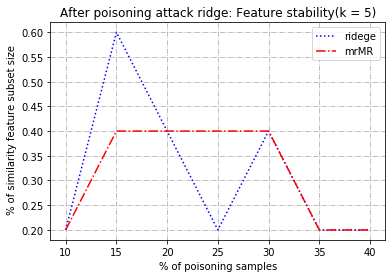

In [335]:
import matplotlib.pyplot as plt
import numpy as np
x = [10, 15, 20, 25, 30, 35, 40]
plt.grid(linestyle='-.')
plt.plot(x, ratio_ridge_5, linestyle=':', color = 'b')
plt.plot(x, ratio_mrMR_5, linestyle='-.', color = 'r')
plt.legend(['ridege', 'mrMR'], loc='upper right')
plt.title('After poisoning attack ridge: Feature stability(k = 5)')
plt.xlabel("% of poisoning samples")
plt.ylabel(" % of similarity feature subset size")
plt.show()

In [310]:
ratio_ridge_10 = []
for i in range(7):
    ratio_ridge_10.append(ratio_ridge[i][1])
ratio_ridge_10

[0.2, 0.5, 0.5, 0.4, 0.6, 0.2, 0.2]

In [311]:
ratio_mrMR_10 = []
for i in range(7):
    ratio_mrMR_10.append(ratio_mrMR[i][1])
ratio_mrMR_10


[0.2, 0.5, 0.6, 0.5, 0.5, 0.4, 0.4]

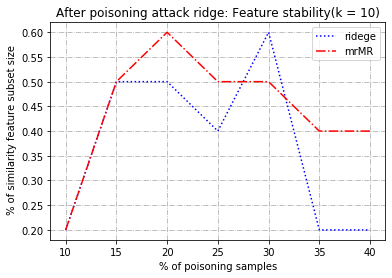

In [336]:
import matplotlib.pyplot as plt
import numpy as np
x = [10, 15, 20, 25, 30, 35, 40]
plt.grid(linestyle='-.')
plt.plot(x, ratio_ridge_10, linestyle=':', color = 'b')
plt.plot(x, ratio_mrMR_10, linestyle='-.', color = 'r')
plt.legend(['ridege', 'mrMR'], loc='upper right')
plt.title('After poisoning attack ridge: Feature stability(k = 10)')
plt.xlabel("% of poisoning samples")
plt.ylabel(" % of similarity feature subset size")
plt.show()

In [305]:
ratio_ridge_15 = []
for i in range(7):
    ratio_ridge_15.append(ratio_ridge[i][2])
ratio_ridge_15

[0.5333333333333333,
 0.5333333333333333,
 0.6666666666666666,
 0.5333333333333333,
 0.6,
 0.4,
 0.4]

In [306]:
ratio_mrMR_15 = []
for i in range(7):
    ratio_mrMR_15.append(ratio_mrMR[i][2])
ratio_mrMR_15

[0.4,
 0.6666666666666666,
 0.6,
 0.6666666666666666,
 0.6,
 0.5333333333333333,
 0.4666666666666667]

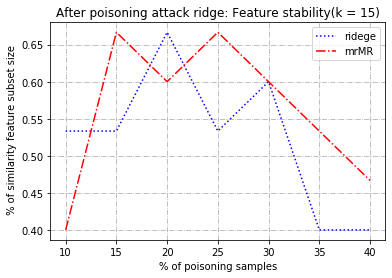

In [337]:
import matplotlib.pyplot as plt
import numpy as np
x = [10, 15, 20, 25, 30, 35, 40]
plt.grid(linestyle='-.')
plt.plot(x, ratio_ridge_15, linestyle=':', color = 'b')
plt.plot(x, ratio_mrMR_15, linestyle='-.', color = 'r')
plt.legend(['ridege', 'mrMR'], loc='upper right')
plt.title('After poisoning attack ridge: Feature stability(k = 15)')
plt.xlabel("% of poisoning samples")
plt.ylabel(" % of similarity feature subset size")
plt.show()

In [ ]:
ratio_ridge_20 = []
for i in range(7):
    ratio_ridge_20.append(ratio_ridge[i][3])
ratio_ridge_20

In [ ]:
ratio_mrMR_20 = []
for i in range(7):
    ratio_mrMR_20.append(ratio_mrMR[i][3])
ratio_mrMR_20


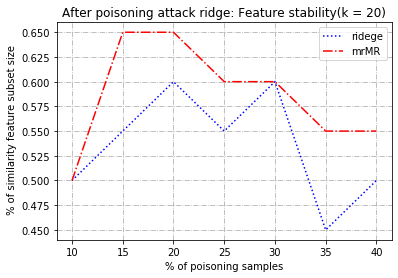

In [338]:
import matplotlib.pyplot as plt
import numpy as np
x = [10, 15, 20, 25, 30, 35, 40]
plt.grid(linestyle='-.')
plt.plot(x, ratio_ridge_20, linestyle=':', color = 'b')
plt.plot(x, ratio_mrMR_20, linestyle='-.', color = 'r')
plt.legend(['ridege', 'mrMR'], loc='upper right')
plt.title('After poisoning attack ridge: Feature stability(k = 20)')
plt.xlabel("% of poisoning samples")
plt.ylabel(" % of similarity feature subset size")
plt.show()

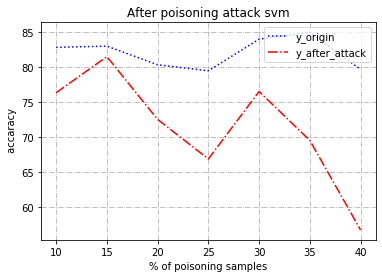

In [341]:
import matplotlib.pyplot as plt
import numpy as np
x = [10, 15, 20, 25, 30, 35, 40]
y_origin = [82.86, 83.03, 80.37, 79.5, 84.03, 85.02, 79.70]
y_after_attack = [76.37, 81.53, 72.55, 66.89, 76.54, 69.55, 56.74]
plt.grid(linestyle='-.')
plt.plot(x, y_origin, linestyle=':', color = 'b')
plt.plot(x, y_after_attack, linestyle='-.', color = 'r')
plt.legend(['y_origin', 'y_after_attack'], loc='upper right')
plt.title('After poisoning attack svm')
plt.xlabel("% of poisoning samples")
plt.ylabel(" accaracy")
plt.show()

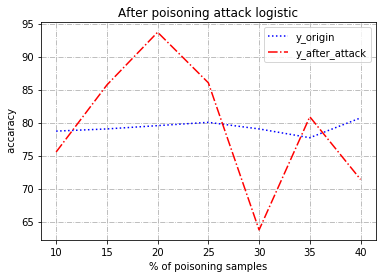

In [342]:
import matplotlib.pyplot as plt
import numpy as np
x = [10, 15, 20, 25, 30, 35, 40]
y_origin = [78.7, 79.03, 79.53, 80.03, 79.03, 77.7, 80.7]
y_after_attack = [75.54, 85.69, 93.68, 86.02, 63.73, 80.87, 71.38]
plt.grid(linestyle='-.')
plt.plot(x, y_origin, linestyle=':', color = 'b')
plt.plot(x, y_after_attack, linestyle='-.', color = 'r')
plt.legend(['y_origin', 'y_after_attack'], loc='upper right')
plt.title('After poisoning attack logistic')
plt.xlabel("% of poisoning samples")
plt.ylabel(" accaracy")
plt.show()

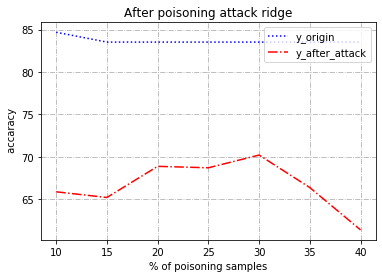

In [343]:
import matplotlib.pyplot as plt
import numpy as np
x = [10, 15, 20, 25, 30, 35, 40]
y_origin = [84.69, 83.53,83.53, 83.53, 83.53, 83.53, 83.53]
y_after_attack = [65.89, 65.22, 68.89, 68.72, 70.22, 66.39, 61.40]
plt.grid(linestyle='-.')
plt.plot(x, y_origin, linestyle=':', color = 'b')
plt.plot(x, y_after_attack, linestyle='-.', color = 'r')
plt.legend(['y_origin', 'y_after_attack'], loc='upper right')
plt.title('After poisoning attack ridge')
plt.xlabel("% of poisoning samples")
plt.ylabel(" accaracy")
plt.show()